In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_activity_per_label(annotation_dict, labels, compute_inverse):
    activity = {}

    for anno in annotation_dict.keys():
        activity[anno] = np.empty((len(annotation_dict[anno]), sum(len(hemi) for hemi in labels)))
        for i, window in enumerate(annotation_dict[anno]):
            stc = compute_inverse(window)
            activity[anno][i] = np.concatenate(get_power_per_label(stc, labels, standardize=False))

    return activity

In [3]:
filepath_open = '../../data/eegmmidb (raw)/files/S001/S001R01.edf'
raw_open = get_raw(filepath_open, filter=True, resample=160)
psd_open = raw_open.compute_psd()

filepath_closed = '../../data/eegmmidb (raw)/files/S001/S001R02.edf'
raw_closed = get_raw(filepath_closed, filter=True, resample=160)
psd_closed = raw_closed.compute_psd()

Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


/home/williamtheodor/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


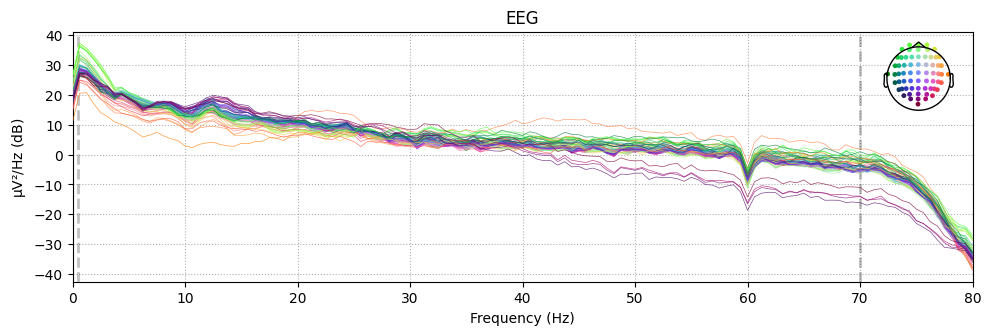

/home/williamtheodor/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


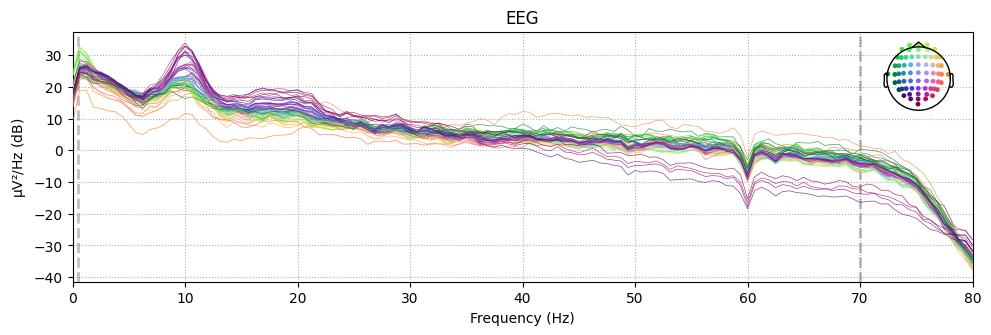

In [4]:
psd_open.plot();
plt.show()
psd_closed.plot();
plt.show()

In [9]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

parcellation_name = "aparc.a2009s"
labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

label_names = [label.name for label in np.array(labels).flatten()]

snr = 1.0
src = get_src(src_path)

In [6]:
info_open = raw_open.info # Just need one raw to get info
fwd_open = get_fwd(info_open, trans, src_path, bem_path)

annotations_open = get_annotations(filepath_open)
annotation_dict_open = get_window_dict(raw_open, annotations_open)

cov_open = get_cov(raw_open)
compute_inverse_open = make_fast_inverse_operator(raw_open.info, fwd_open, cov_open, snr=snr)


############################################################################################

info_closed = raw_closed.info # Just need one raw to get info
fwd_closed = get_fwd(info_closed, trans, src_path, bem_path)

annotations_closed = get_annotations(filepath_closed)
annotation_dict_closed = get_window_dict(raw_closed, annotations_closed)

cov_closed = get_cov(raw_closed)
compute_inverse_closed = make_fast_inverse_operator(raw_closed.info, fwd_closed, cov_closed, snr=snr)

In [10]:
activity_open_sanity = calculate_activity_per_label(annotation_dict_open, labels, compute_inverse_open)
activity_closed_sanity = calculate_activity_per_label(annotation_dict_closed, labels, compute_inverse_closed)

In [11]:
# sort dict by keys
def sort_dict(dict):
    return {k: dict[k] for k in sorted(dict.keys())}

DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'
PARCELLATION = 'aparc.a2009s'
#PARCELLATION = 'HCPMMP1_combined'
PARCELLATION_PATH = DATA_PATH + 'mmidb_' + PARCELLATION + '/mmidb_'+ PARCELLATION

delta_activity = np.load(PARCELLATION_PATH + '_1.0_1.0_4.0_parallel.npy', allow_pickle=True).item()
theta_activity = np.load(PARCELLATION_PATH + '_1.0_4.0_8.0_parallel.npy', allow_pickle=True).item()
alpha_activity = np.load(PARCELLATION_PATH + '_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()
beta_activity = np.load(PARCELLATION_PATH + '_1.0_12.0_30.0_parallel.npy', allow_pickle=True).item()
gamma_activity = np.load(PARCELLATION_PATH + '_1.0_30.0_70.0_parallel.npy', allow_pickle=True).item()

data = {
    'Delta': sort_dict(delta_activity),
    'Theta': sort_dict(theta_activity),
    'Alpha': sort_dict(alpha_activity),
    'Beta': sort_dict(beta_activity),
    'Gamma': sort_dict(gamma_activity)
}

In [12]:
open_sanity = activity_open_sanity['T0'][0]
closed_sanity = activity_closed_sanity['T0'][0]
total_sanity = open_sanity + closed_sanity

patient = 'S001'
open_calculated = data['Alpha'][patient][patient+'R01']['T0'][0]
closed_calculated = data['Alpha'][patient][patient+'R02']['T0'][0]
total_calculated = open_calculated + closed_calculated

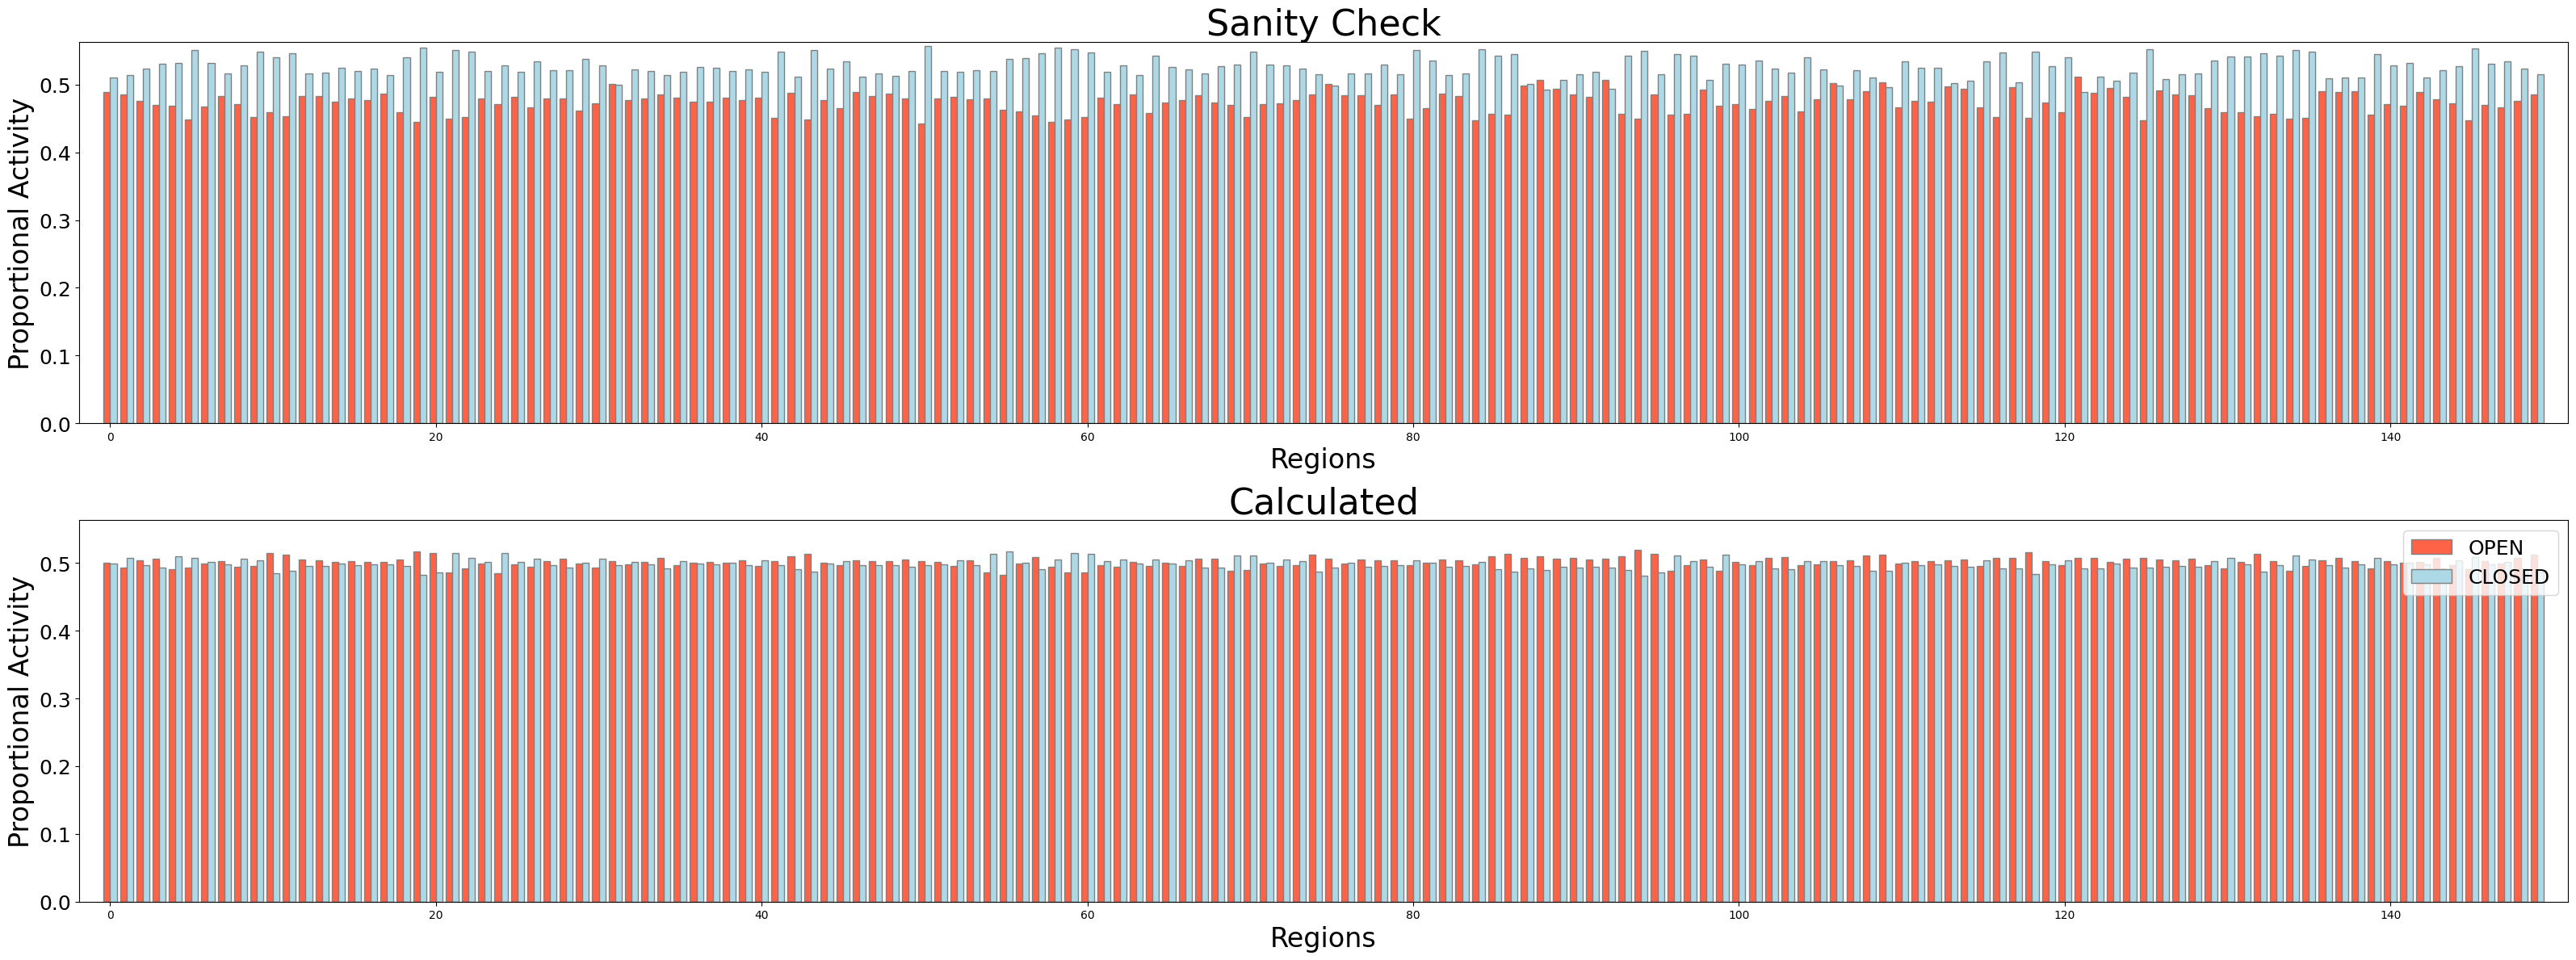

In [23]:
 # Label sizes
TICK_LABEL_SIZE = 18
AXIS_LABEL_SIZE = 24
TITLE_LABEL_SIZE = 32

# set width of bar
barWidth = 0.4

# make plot
fig, axes = plt.subplots(2, 1, figsize=(32, 12), sharey=True)

# Set position of bar on X axis
X = np.arange(activity_open_sanity['T0'].shape[1])
br1 = [x - barWidth/2 for x in X]
br2 = [x + barWidth/2 for x in X]

left_color = 'tomato'
right_color = 'lightblue'



# Make the plot
axes[0].bar(br1, open_sanity/total_sanity, color=left_color, width = barWidth,
        edgecolor ='grey', label ='OPEN')
axes[0].bar(br2, closed_sanity/total_sanity, color=right_color, width = barWidth,
        edgecolor ='grey', label ='CLOSED')
axes[0].set_title('Sanity Check', fontsize=TITLE_LABEL_SIZE)

axes[1].bar(br1, open_calculated/total_calculated, color=left_color, width = barWidth,
        edgecolor ='grey', label ='OPEN')
axes[1].bar(br2, closed_calculated/total_calculated, color=right_color, width = barWidth,
        edgecolor ='grey', label ='CLOSED')
axes[1].set_title('Calculated', fontsize=TITLE_LABEL_SIZE)


for ax in axes:
        # Adding ticks
        ax.set_xlabel('Regions', fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel('Proportional Activity', fontsize=AXIS_LABEL_SIZE)
        #ax.set_xticks(X, label_names, fontsize=TICK_LABEL_SIZE, rotation=90)
        ax.margins(.01)
        ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)



plt.tight_layout() 
plt.legend(fontsize=TICK_LABEL_SIZE)

plt.show()